In [50]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Colormap for time
import scienceplots
plt.style.use(['science','nature','no-latex','vibrant'])


from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.signal import find_peaks



#Import personal functions
import sys
#sys.path.append("C:/Users/Olivi/OneDrive - TU Eindhoven/Soft robotic matter/GitHub/Thermal_Soft_Robotics/Functions")
sys.path.append("//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Functions")
import FluidicSetupFunctions
from save_plot_func import save_plot


In [11]:
#Location = r"C:\Users\Olivi\OneDrive - TU Eindhoven\Soft robotic matter\data_analysis"
Location = r"//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Thermal_actuation/Experimental/Fluidic/Actuators"
Foldernames = ["/Data"]

data = FluidicSetupFunctions.LoadData(Foldernames = Foldernames,Location=Location)

print(data[0][-1].head)


Loading... Folder 1 of 1, Sample 1 of 5
Loading... Folder 1 of 1, Sample 2 of 5
Loading... Folder 1 of 1, Sample 3 of 5
Loading... Folder 1 of 1, Sample 4 of 5
Loading... Folder 1 of 1, Sample 5 of 5
<bound method NDFrame.head of         flowFesto-1  DigOut-1   SSCDP30-9     Time
0          0.000037       0.0   50.559083    0.001
1         -0.000010       0.0   40.280822    0.002
2         -0.000120       0.0   31.262755    0.003
3         -0.000281       0.0   23.466631    0.004
4         -0.000481       0.0   16.854201    0.005
...             ...       ...         ...      ...
211295     0.001067       0.0  230.873302  211.296
211296     0.001259       0.0  234.478685  211.297
211297     0.001422       0.0  237.512370  211.298
211298     0.001553       0.0  239.694656  211.299
211299     0.001645       0.0  240.745842  211.300

[211300 rows x 4 columns]>


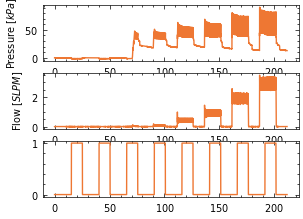

In [17]:
P = data[0][0]['SSCDP30-9']/1000
t = data[0][0]['Time']
Q = data[0][0]['flowFesto-1']
digout = data[0][0]['DigOut-1']


ax1=plt.subplot(311)
plt.plot(t,P)

plt.ylabel('Pressure [$kPa$]')

ax2 = plt.subplot(312,sharex=ax1)
plt.plot(t,Q)
plt.xlabel('Time[$s$]')
plt.ylabel('Flow [$SLPM$]')


ax3 = plt.subplot(313,sharex=ax1)
plt.plot(t,digout)

plt.show()

Prepare data: slice per run

In [45]:
# Slice data per run 
data_sliced = []
for index,value in enumerate(data[0]):
    runs = [] # new list for all the runs in data[0]
    start = 0
    run_count = 1  # Counter for run number

    df = data[0][index]
    print(index)

    P = data[0][0]['SSCDP30-9']
    t = data[0][0]['Time']
    Q = data[0][0]['flowFesto-1']
   

    while start < len(data[0][index]['DigOut-1']):
        start = np.argmax(data[0][index]['DigOut-1'][start:] == 1) +start  # Correcting index for slicing
        end = np.argmax(data[0][index]['DigOut-1'][start:] == 0)+start   # Correcting index for slicing
        
        if end <= start:  # Break if no more valid segments are found
            break        
      
        # Create a DataFrame for this run
        run_df = pd.DataFrame({
            'Time': t[start:end]-t[start], 
            'Flow': Q[start:end],
            'Pressure': P[start:end]/1000   
        })

        # Append this DataFrame to the list
        runs.append(run_df)   

        start = end + 5  # Move to next segment
        run_count += 1  # Increment run counter

   
    data_sliced.append(runs)
    break



0


192


19.131127939418096

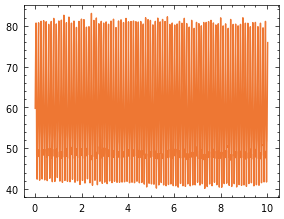

In [67]:
len(data_sliced[0])
data_sliced[0][0]
plt.plot(data_sliced[0][7]["Time"],data_sliced[0][7]["Pressure"])
np.mean(data_sliced[0][7]["Flow"])

peaks,_ = find_peaks(data_sliced[0][7]["Pressure"])
n_peaks=len(peaks)
print(n_peaks)
len(data_sliced[0][7]["Time"]/1000)
measurement_t = len(data_sliced[0][7]["Time"])/1000
f = n_peaks/measurement_t 
f

0          Time      Flow  Pressure
15264   0.000  0.000261 -0.555508
15265   0.001  0.000558 -0.686725
15266   0.002  0.000750 -0.817942
15267   0.003  0.000833 -0.944425
15268   0.004  0.000501 -1.061442
...       ...       ...       ...
25287  10.023 -0.000514 -1.307241
25288  10.024 -0.000621 -1.185153
25289  10.025 -0.000627 -1.058568
25290  10.026 -0.000824 -0.912001
25291  10.027 -0.000729 -0.765637

[10028 rows x 3 columns]
1          Time      Flow  Pressure
40421   0.000 -0.000288 -0.552871
40422   0.001 -0.000101 -0.668873
40423   0.002 -0.000200 -0.794883
40424   0.003 -0.000122 -0.911393
40425   0.004 -0.000063 -1.034563
...       ...       ...       ...
50445  10.024  0.002458 -1.352479
50446  10.025  0.002249 -1.213283
50447  10.026  0.002013 -1.064485
50448  10.027  0.001694 -0.901486
50449  10.028  0.001306 -0.738353

[10029 rows x 3 columns]
2          Time      Flow   Pressure
65549   0.000  0.000699  -0.492756
65550   0.001  0.000349  -0.610956
65551   0.002  0.0000

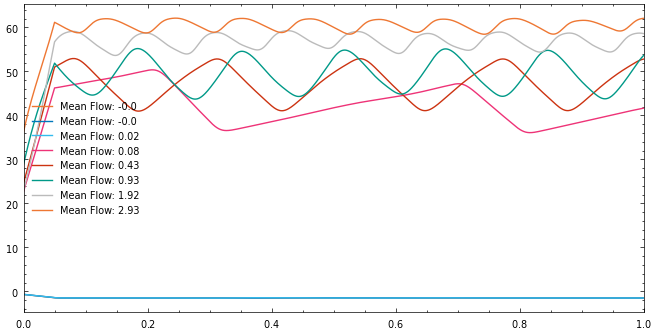

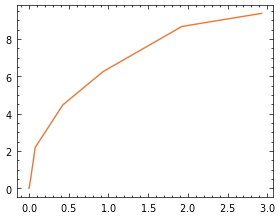

In [131]:
from scipy.signal import find_peaks, butter, filtfilt

# Butterworth filter design
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function for moving average smoothing
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')


# Define sampling rate and cutoff frequency
fs = 1000  # example sampling rate
cutoff = 30  # cutoff frequency in Hz for low-pass filter

# Window size for smoothing
window_size = 100 

plt.figure(figsize=(8, 4))

Q_mean = []
f=[]

for i,run_data in enumerate(data_sliced[0]):
    time = run_data["Time"]
    P_raw = run_data["Pressure"]
    Q_mean.append(np.mean(run_data["Flow"]))
    
    # Filter the signal
    filtered_pressure = butter_lowpass_filter(P_raw, cutoff, fs)
    P = moving_average(filtered_pressure,window_size)

    # Find peaks with dynamic thresholding and minimum distance
    peaks, _ = find_peaks(P,height=40)
    n_peaks = len(peaks)

    
    measurement_t = len(data_sliced[0][i]["Time"])/1000
    f.append(n_peaks/measurement_t )


# Correct usage of np.round and np.mean for labeling
    mean_flow = np.round(np.mean(run_data["Flow"]), 2)
    plt.plot(time, P, label=f'Mean Flow: {mean_flow}')
    #plt.plot(time[peaks], pressure[peaks], "x")
    print(i,run_data)



# Set the x and y limits if needed
# plt.xlim(0, 1)
# plt.ylim(-2, -1)
plt.xlim(0,1)
plt.legend()
plt.show()
plt.plot(Q_mean,f)





Extract opening and closing pressure

In [308]:

# Function for moving average smoothing
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Plot sliced data and extract opening pressure 
P_open = []
P_close = []

open_threshold = 0.1 # slpm
close_threshold = 0.09 # slpm

# Window size for smoothing
window_size = 100  # You can adjust this value based on your requirements

# Initialize a flag to indicate whether the threshold has been crossed from below
crossed_threshold = False

for sample in data_sliced:   
    # Initialize lists for each sample
    P_open_sample = []
    P_close_sample = []
    
    for run in sample:
        Q_raw = run['Rescaled_Flow']
        P_raw = run['Pressure']
        
        # Apply moving average smoothing
        Q = moving_average(Q_raw, window_size)
        P_sliced = moving_average(P_raw, window_size)
        
        # Extract opening pressure
        opening_index = np.argmax(Q > open_threshold)  # If the flow passes a certain threshold, then we can assume it is open
        P_open_sample.append(P_sliced[opening_index])  # Use previous index to recover the pressure 
        
        # Loop through the data
        for jj in range(1, len(Q)):
            # Check for crossing the threshold from below to above
            if Q[jj] > close_threshold:
                crossed_threshold = True
            
            # Check for crossing the threshold from above to below after it's been crossed from below
            if crossed_threshold and Q[jj] < close_threshold:
                P_close_sample.append(P_sliced[jj])
                
                # Reset the flag if you are only interested in the first such occurrence
                crossed_threshold = False
                break
    
    # Append the lists for each sample to the main lists
    P_open.append(P_open_sample)
    P_close.append(P_close_sample)

Results